# Лабораторная работа №5: Методы,основанные на деревьях решений.Регрессионные деревья. Деревья классификации.Случайный лес. Бустинг.

**Номер варианта: 12**

**Данные: winequality-white_for_lab**

**Зависимая переменная: Y**

**Объясняющие переменные: все, кроме quality и Y**

**Метод построения дерева решений: Boosting**

**Задание :**
1. Данные своего варианта из упражнения 3 (на регуляризацию и снижение размерности)
разделить на выборку для построения моделей (85%) и отложенные наблюдения (15%).
Отложенные наблюдения использовать только для прогноза по лучшей модели.
2. Построить модель дерева с обрезкой ветвей и оптимизировать её параметр с помощью
перекрёстной проверки. Указать, чему равно оптимальное значение параметра.
Представить дерево графически, если его размер позволяет.
3. Построить модель методом, указанным в варианте (см. таблицу ниже), оптимизировав её
параметры с помощью перекрёстной проверки. Для сеточного поиска взять не менее 7
различных значений для каждого настроечного параметра. Указать оптимальные значения
параметров.
4. Выбрать наиболее точную модель из полученных в пунктах 2 и 3.
5. Сделать по ней прогноз на отложенные наблюдения, оценить точность этого прогноза.
6. Сравнить точность на отложенных наблюдениях с точностью моделей из упражнения 4

---



# Загрузка модулей, констант, данных (из лабораторной №4)

**Загрузка модулей**

In [ ]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
from matplotlib import pyplot as plt
# для таймера
import time
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score
# дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
# сводка по точности классификации
from sklearn.metrics import classification_report

In [ ]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
C_min_pow=-4, C_max_pow=3.):
    fig = plt.figure()
    ax = plt.subplot(111)

    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)

    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name,
            C=10.**c, solver='liblinear',
            multi_class='ovr', random_state=SEED)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)
    weights = np.array(weights)
    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
            label=col_names[column],
            color=color)
    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta',
    linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center',
        bbox_to_anchor=(1.38, 1.03),
        ncol=1, fancybox=True)
    plt.show()


**Константы**

In [ ]:
SEED = 12
TRAIN_RATIO = 0.85
sns.set_style("whitegrid")
sns.set_palette("deep")

**Загрузка данных**

In [ ]:
fileURL = "https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-white_for_lab.csv"
df_all = pd.read_csv(fileURL)
df_all = df_all.drop("quality", axis=1)

In [ ]:
df_all.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

**Разделение данных на тренировочную и тестовую выборки**

In [ ]:
df_train = df_all.sample(frac=TRAIN_RATIO, random_state=SEED)
df_test = df_all.drop(df_train.index)

# Предварительный анализ данных (Из Лабораторной №4)

**Описательные статистики**

Считаем доли классов целевой переменной Y

In [ ]:
df_train["Y"].unique()

array([1, 0])

Доли классов в тренировочной выборке

In [ ]:
np.around(df_train["Y"].value_counts() / len(df_train.index), 3)

Y
1    0.663
0    0.337
Name: count, dtype: float64

Рассчитаем описательные статистики для объясняющих переменных

In [ ]:
df_train.iloc[:, :6].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,6.856318,0.277989,0.335719,6.438218,0.046030,35.388662
std,0.840313,0.101073,0.122165,5.035408,0.022404,17.017232
min,3.800000,0.080000,0.000000,0.600000,0.012000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000
50%,6.800000,0.260000,0.320000,5.300000,0.043000,34.000000
75%,7.300000,0.320000,0.390000,10.000000,0.050000,46.000000
max,14.200000,1.100000,1.660000,31.600000,0.346000,289.000000


In [ ]:
df_train.iloc[:, 6:11].describe()

,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4163.000000,4163.000000,4163.000000,4163.000000,4163.000000
mean,138.513572,0.994055,3.187881,0.489683,10.500002
std,42.575390,0.002936,0.150310,0.113528,1.232046
min,18.000000,0.987110,2.720000,0.220000,8.000000
25%,108.000000,0.991730,3.090000,0.410000,9.400000
50%,134.000000,0.993800,3.180000,0.480000,10.400000
75%,168.000000,0.996200,3.280000,0.550000,11.400000
max,440.000000,1.010300,3.810000,1.080000,14.200000


Выводы по описательным статистикам: значения объясняющих переменных положительные,
масштабы измерения отличаются. Для работы с методами снижения размерности и
регуляризации понадобится стандартизация значений.

**Визуализация разброса переменных внутри классов**

Поскольку в наборе данных 11 объясняющих переменных, и все они непрерывные, анализ
матричного графика разброса будет затруднительным. Построим коробчатые диаграммы дляобъясняющих переменных, чтобы сравнить средние уровни и разброс по классам.

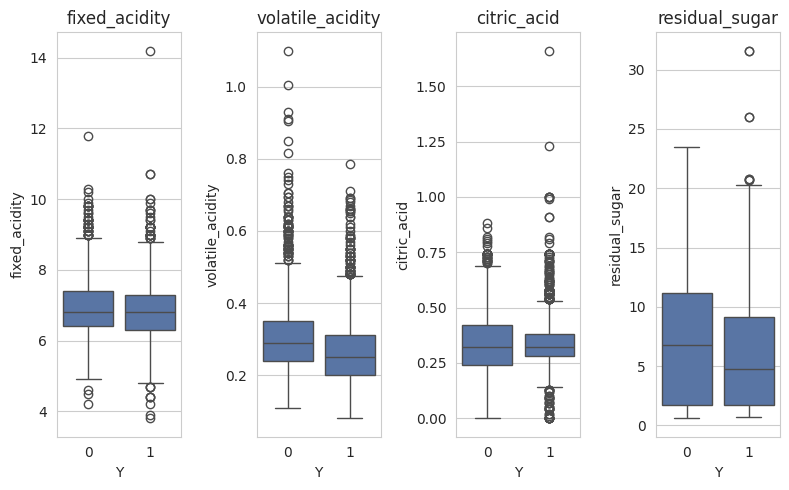

In [ ]:
fig = plt.figure(figsize=(8, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
axs = [ax1, ax2, ax3, ax4]
cols_loop = list(df_train.columns[:4].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df_train, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

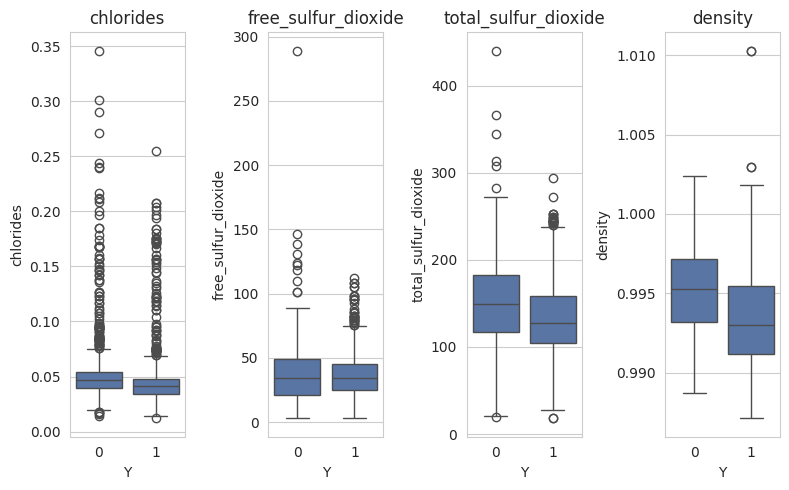

In [ ]:
fig = plt.figure(figsize=(8, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
axs = [ax1, ax2, ax3, ax4]
cols_loop = list(df_train.columns[4:8].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df_train, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

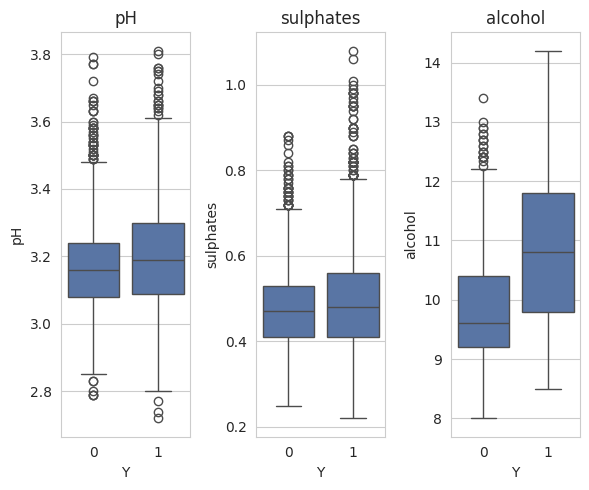

In [ ]:
fig = plt.figure(figsize=(6, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
axs = [ax1, ax2, ax3, ax4]
cols_loop = list(df_train.columns[8:11].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=df_train, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по большинству объясняющих переменных. Меньше всего различаются коробчатые диаграммы по
переменной `fixed_acidity` . Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по объясняющим переменным.

# Дерево с обрезкой ветвей

Формирование выборки

In [ ]:
X = df_train.drop(["Y"], axis=1)
y = df_train["Y"]

Построение простого дерева решений для поиска параметра alpha

In [ ]:
cls_one_tree = DecisionTreeClassifier(criterion="entropy",
                                      random_state=SEED)

tree_full = cls_one_tree.fit(X, y)

tree_full.get_n_leaves()

582

In [ ]:
tree_full.get_depth()

25

Поиск и отображение всех возможных параметров alpha

Всего значений alpha: 327
Энтропия листьев для первых 5 значений alpha: [0.         0.00086708 0.00173415 0.00267101 0.00315143]


Text(0.5, 1.0, 'Изменение показателя нечистоты узлов с ростом alpha')

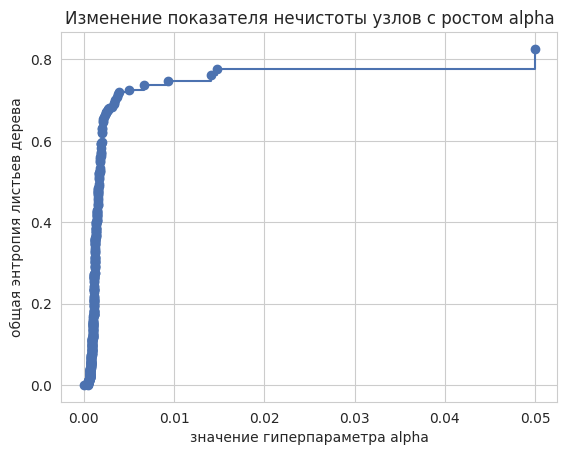

In [ ]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")

Поиск оптимального параметра для обрезки ветвей

In [ ]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y,
random_state=SEED)
# модели
clfs = list()
# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=SEED, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 10.54 секунд


In [ ]:
# извлекаем характеристики глубины и точности
# таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
# таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 1.52 секунд


Графики изменения сложности и точности модели при изменении параметра

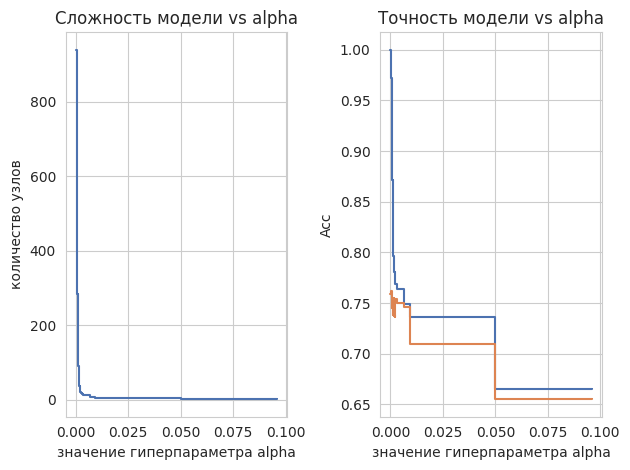

In [ ]:
fig, ax = plt.subplots(1, 2)
# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")
# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели vs alpha")
fig.tight_layout()

Построение дерева решений с оптимальным значением параметра с перекрестной проверкой.

In [ ]:
score = list()
score_models = list()
opt_ind = test_scores.index(max(test_scores))
opt_nodes_num = node_counts[opt_ind]
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_ind], X=X, y=y, cv=5,
scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')
print('Оптимальное количество узлов:', opt_nodes_num,
'\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
'\n\nAcc с перекрёстной проверкой',
'\nдля модели', score_models[0], ':', score[0])

Оптимальное количество узлов: 679 
соответствующая Acc на тестовой: 0.762 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.774


Оптимальное значение параметра

In [ ]:
ccp_alphas[opt_ind]

0.00043353837069863213

Глубина оптимального дерева

In [ ]:
clfs[opt_ind].get_depth()

20

# Бустинг

Бустинг-дерево с произвольными параметрами N = 100 - числом деревьев, learning_rate = 1 - скоростью обучения, max_depth = 1 - глубиной деревьев.

In [ ]:
# обучаем модель с параметрами по умолчанию
kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=SEED)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)

0.77

Подбор параметров для бустинг-дерева

In [ ]:
# настроим параметры бустинга с помощью сеточного поиска
param_grid = {'n_estimators' : [15, 25, 35, 45, 55],
'learning_rate' : np.linspace(start=0.01, stop=0.4, num=20),
'max_depth' : [1, 2, 3]}
# таймер
tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(),
param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 300.69 секунд


Точность лучшего бустинг-дерева

In [ ]:
np.around(boost_tree.best_score_, 3)

0.793

In [ ]:
# записываем точность
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')

Параметры лучшей модели

In [ ]:
print('n_estimators:', boost_tree.best_estimator_.get_params()['n_estimators'],
    '\nlearning_rate:', boost_tree.best_estimator_.get_params()['learning_rate'],
    '\nmax_depth:', boost_tree.best_estimator_.get_params()['max_depth'])

n_estimators: 55 
learning_rate: 0.33842105263157896 
max_depth: 3


# Выбор лучшей модели и прогнозирование

In [ ]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,pruned_tree,0.774
1,boost_tree_GS,0.793


In [ ]:
# данные для прогноза
X_pred = df_test.drop(['Y'], axis=1)
# строим прогноз
y_hat = boost_tree.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(df_test['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.72      0.64      0.67       237
           1       0.84      0.88      0.86       498

    accuracy                           0.80       735
   macro avg       0.78      0.76      0.77       735
weighted avg       0.80      0.80      0.80       735



Пресказания бустинг-деревом имеют точность 80%, а лассо-регрессией - 76%. При этом для бустинг-дерева f1 значения равны 0.67 и 0.86, а для лассо-регрессии - 0.56 и 0.83 соответственно. Значит, бустинг-дерево лучше предсказывает значения и является более надежной моделью.